# Project 2 ChE 2410
### Replication of the study: A general kinetic model for the hydrothermal liquefaction of microalgae

_Peter J. Valdez, Vincent J. Tocco, Phillip E. Savage_ 

2014, Bioresource Journal


$\dot{x}_{1_p} = -(k_{1_p} + k_{2_p}) \cdot x_{1_p} $

$\dot{x}_{1_1} = -(k_{1_1} + k_{2_1}) \cdot x_{1_1} $

$\dot{x}_{1_c} = -(k_{1_c} + k_{2_c}) \cdot x_{1_c} $

$\dot{x}_2 = -(k_4 + k_5) \cdot x_2 + k_{1_p} \cdot x_{1_p} + k_{1_1} \cdot x_{1_1} + k_{1_c} \cdot x_{1_c} + k_3 \cdot x_3 $

$\dot{x}_3 = -(k_3 + k_6) \cdot x_3 + k_{2_p} \cdot x_{1_p} + k_{2_1} \cdot x_{1_1} + k_{2_c} \cdot x_{1_c} + k_4 \cdot x_2 $

$\dot{x}_4 = k_5 \cdot x_2 + k_6 \cdot x_3 $

$x_1 = x_{1_p} + x_{1_1} + x_{1_c}$


In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize

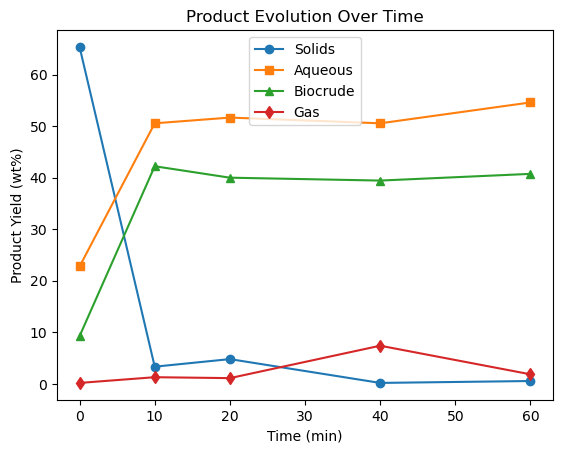

In [2]:
time = np.array([0, 10, 20, 40, 60])
solids = np.array([65.37,3.33,4.8,0.18,0.55])
protein = solids * 0.56
carbs = solids * 0.32
lipids = solids * 0.09
aqueous = np.array([22.77,50.55,51.66,50.55,54.6])
biocrude = np.array([9.26,42.22,40,39.44,40.74])
gas = np.array([0.18,1.29,1.11,7.4,1.85])

plt.plot(time, solids, label='Solids', marker='o')
plt.plot(time, aqueous, label='Aqueous', marker='s')
plt.plot(time, biocrude, label='Biocrude', marker='^')
plt.plot(time, gas, label='Gas', marker='d')

plt.title('Product Evolution Over Time')
plt.xlabel('Time (min)')
plt.ylabel('Product Yield (wt%)')
plt.legend()
plt.show()

The behavior of solids does not make any sense, because at time equals zero, the concentration of solids must be higher. This is the data reported in the paper but the plot is different.

In [3]:
training_data = np.vstack((protein, lipids, carbs, aqueous, biocrude, gas)).T
print(training_data)

[[3.66072e+01 5.88330e+00 2.09184e+01 2.27700e+01 9.26000e+00 1.80000e-01]
 [1.86480e+00 2.99700e-01 1.06560e+00 5.05500e+01 4.22200e+01 1.29000e+00]
 [2.68800e+00 4.32000e-01 1.53600e+00 5.16600e+01 4.00000e+01 1.11000e+00]
 [1.00800e-01 1.62000e-02 5.76000e-02 5.05500e+01 3.94400e+01 7.40000e+00]
 [3.08000e-01 4.95000e-02 1.76000e-01 5.46000e+01 4.07400e+01 1.85000e+00]]


In [4]:
def MyODEs(y,t, k1_p,k2_p,k1_1, k2_1,k1_c, k2_c, k4,k5, k3, k6):
    xp, xl, xc, x2, x3, x4 = y
    dxpdt = -(k1_p + k2_p) * xp  # proteins
    dxldt = -(k1_1 + k2_1) * xl  # lipids
    dxcdt = -(k1_c + k2_c) * xc  # carbs
    dx2dt = -(k4 + k5) * x2 + k1_p * xp + k1_1 * xl + k1_c * xc + k3 * x3  # aqueous phase
    dx3dt = -(k3 + k6) * x3 + k2_p * xp + k2_1 * xl + k1_c * xc + k4 * x2  # biocrude
    dx4dt = k5 * x2 + k6 * x3  # gas
    return [dxpdt, dxldt, dxcdt, dx2dt, dx3dt, dx4dt]

In [5]:
t_steps = np.array([0, 10, 20, 40, 60])
y0_2 = np.array([protein[0], lipids[0], carbs[0], aqueous[0], biocrude[0], gas[0]])
def RMSE_MyODEs(params):
    k1_p, k2_p, k1_1, k2_1, k1_c, k2_c, k4, k5, k3, k6 = params
    ODE_output = odeint(MyODEs, y0_2, t_steps, args=(k1_p, k2_p, k1_1, k2_1, k1_c, k2_c, k4, k5, k3, k6))
    err = training_data - ODE_output
    return np.sqrt(np.sum(err**2))

In [6]:
bounds = [(0, None), (0, None), (0, None), (0, None), (0, None), 
          (0, None), (0, None), (0, None), (0, None), (0, None)]
initial_guess = [0.18, 0.11, 0.29, 0.10, 0.28, 0.00008, 0.1, 0.0002, 0.1, 0.00019]
result = minimize(RMSE_MyODEs, initial_guess, bounds=bounds)

print(result)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 7.249566743001406
        x: [ 1.172e-01  1.880e-01  3.101e-01  1.353e-01  1.588e-01
             1.627e-01  2.453e-02  0.000e+00  3.206e-02  1.652e-03]
      nit: 117
      jac: [-8.280e-03  5.568e-03 -1.824e-03 -2.973e-02 -1.553e-02
             1.233e-02  1.478e-01  2.743e+01 -1.197e-01  2.132e-01]
     nfev: 1749
     njev: 159
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>


In [7]:
optimized_params = result.x
print("Optimized Parameters:")
print("k1_p:", optimized_params[0])
print("k2_p:", optimized_params[1])
print("k1_1:", optimized_params[2])
print("k2_1:", optimized_params[3])
print("k1_c:", optimized_params[4])
print("k2_c:", optimized_params[5])
print("k4:", optimized_params[6])
print("k5:", optimized_params[7])
print("k3:", optimized_params[8])
print("k6:", optimized_params[9])

Optimized Parameters:
k1_p: 0.11720054583394836
k2_p: 0.18798439006590936
k1_1: 0.3100758610406755
k2_1: 0.13526593674279422
k1_c: 0.15881071233055613
k2_c: 0.16271956895528125
k4: 0.024527885103684106
k5: 0.0
k3: 0.03205828150490094
k6: 0.001651624628330452


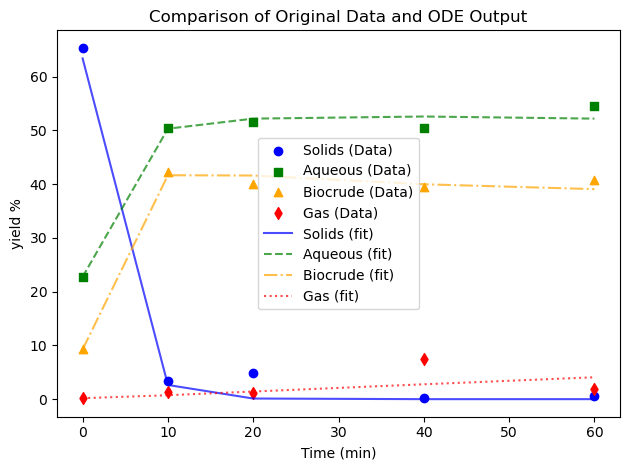

In [8]:
ODE_output_results = odeint(MyODEs, y0_2, t_steps, args=(optimized_params[0], optimized_params[1], optimized_params[2], optimized_params[3], optimized_params[4], optimized_params[5],optimized_params[6],optimized_params[7], optimized_params[8],optimized_params[9]))
ODE_output_results_solids = ODE_output_results[:, 0] + ODE_output_results[:, 1] + ODE_output_results[:, 2]
ODE_output_results_aqueous = ODE_output_results[:, 3]
ODE_output_results_biocrude = ODE_output_results[:, 4]
ODE_output_results_gas = ODE_output_results[:, 5]

plt.scatter(t_steps, solids, label='Solids (Data)', marker='o', color='blue')
plt.scatter(t_steps, aqueous, label='Aqueous (Data)', marker='s', color='green')
plt.scatter(t_steps, biocrude, label='Biocrude (Data)', marker='^', color='orange')
plt.scatter(t_steps, gas, label='Gas (Data)', marker='d', color='red')

plt.plot(t_steps, ODE_output_results_solids, label='Solids (fit)', linestyle='-', color='blue', alpha=0.7)
plt.plot(t_steps, ODE_output_results_aqueous, label='Aqueous (fit)', linestyle='--', color='green', alpha=0.7)
plt.plot(t_steps, ODE_output_results_biocrude, label='Biocrude (fit)', linestyle='-.', color='orange', alpha=0.7)
plt.plot(t_steps, ODE_output_results_gas, label='Gas (fit)', linestyle=':', color='red', alpha=0.7)

plt.xlabel('Time (min)')
plt.ylabel('yield %')
plt.title('Comparison of Original Data and ODE Output')
plt.legend(loc='best')

plt.tight_layout()  
plt.show()

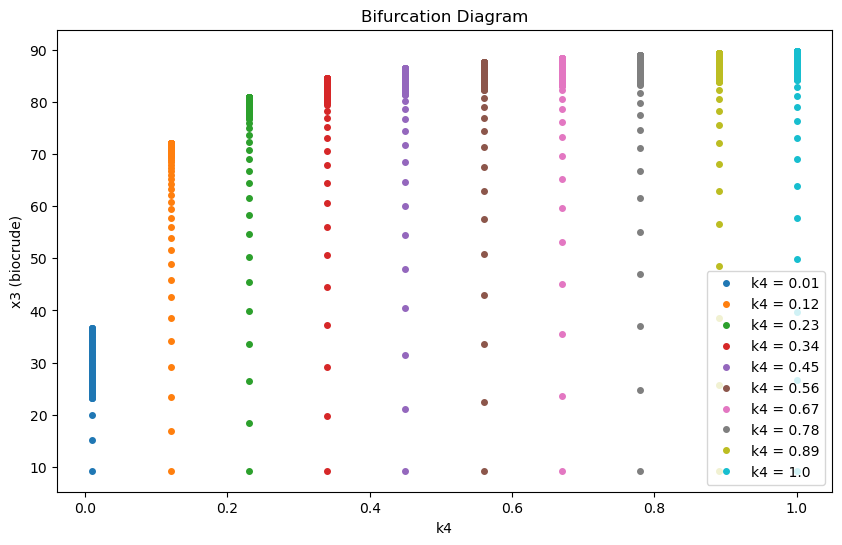

In [10]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

initial_y = y0_2
k1_p = optimized_params[0]
k2_p = optimized_params[1]
k1_1 = optimized_params[2]
k2_1 = optimized_params[3]
k1_c = optimized_params[4]
k2_c = optimized_params[5]
k5 = optimized_params[7]
k3 = optimized_params[8]
k6 = optimized_params[9]

def MyODEs_2(y, t, k4):
    xp, xl, xc, x2, x3, x4 = y
    dxpdt = -(k1_p + k2_p) * xp  # proteins
    dxldt = -(k1_1 + k2_1) * xl  # lipids
    dxcdt = -(k1_c + k2_c) * xc  # carbs
    dx2dt = -(k4 + k5) * x2 + k1_p * xp + k1_1 * xl + k1_c * xc + k3 * x3  # aqueous phase
    dx3dt = -(k3 + k6) * x3 + k2_p * xp + k2_1 * xl + k1_c * xc + k4 * x2  # biocrude
    dx4dt = k5 * x2 + k6 * x3  # gas
    return [dxpdt, dxldt, dxcdt, dx2dt, dx3dt, dx4dt]

k4_test = np.linspace(0.01, 1, 10)
x3_values = np.linspace(0, 60, 100)

plt.figure(figsize=(10, 6))

for k4_val in k4_test:
    x3_final_values = []
    for x3_val in x3_values:
        y = odeint(MyODEs_2, initial_y, [0, x3_val], args=(k4_val,))
        x3_final_values.append(y[-1, 4])  # Extract x3 value at the final time point

    plt.plot(k4_val * np.ones_like(x3_values), x3_final_values, 'o', markersize=4, label=f'k4 = {k4_val}')

plt.xlabel("k4")
plt.ylabel("x3 (biocrude)")
plt.title("Bifurcation Diagram")
plt.legend()
plt.show()